<a href="https://colab.research.google.com/github/Felix-Busse/Autoencoder---images-with-pattern/blob/main/t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training t-SNE on activations in bottleneck of autoencoder

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow.keras as ks

2024-05-24 13:13:00.936478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 13:13:01.504465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 13:13:01.508250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 13:13:03.186110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load image dataset CIFAR10

In [2]:
# Loading data
(x_train, y_cat_train), (x_test, y_cat_test) = ks.datasets.cifar10.load_data()
# Normalizing to values from 0 to 1, reducing to 20.000 sample images
x_train = x_train.astype('float')/ 255 
y_train = x_train.copy() # Target is same as input for autoencoders
# Normalizing test data set the same way
x_test = x_test.astype('float') / 255

### Setting up and training autoencoder network on training images

In [3]:
# Defining activation function to be used in autoencoder
activ = 'selu'

# Setting up convolutional autoencoder
Net = ks.Sequential()
Net.add(ks.layers.Conv2D(16, 3, activation=activ, padding='same', input_shape=(32, 32, 3)))
Net.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 32x32 to 16x16
Net.add(ks.layers.Conv2D(32, 3, activation=activ, padding='same'))
Net.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 16x16 to 8x8
Net.add(ks.layers.Conv2D(64, 3, activation=activ, padding='same'))
Net.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 8x8 to 4x4
Net.add(ks.layers.Conv2D(8, 3, activation=activ, padding='same')) # Bottleneck with 8 channels 4x4 px = 128 neurons
Net.add(ks.layers.UpSampling2D(size=(2, 2))) # From 4x4 to 8x8
Net.add(ks.layers.Conv2D(64, 3, activation=activ, padding='same'))
Net.add(ks.layers.UpSampling2D(size=(2, 2))) # From 8x8 to 16x16
Net.add(ks.layers.Conv2D(32, 3, activation=activ, padding='same'))
Net.add(ks.layers.UpSampling2D(size=(2, 2))) # From 16x16 to 32x32
Net.add(ks.layers.Conv2D(16, 3, activation=activ, padding='same'))
Net.add(ks.layers.Conv2D(3, 5, activation='sigmoid', padding='same')) # Output layer with 3 color channels

# Defining loss-function and optimizer
Net.compile(loss='MeanSquaredError', optimizer='adam')
# empty list as storage for loss information
history_buffer = []

In [ ]:
# Fitting model to training data
history = Net.fit(x_train, y_train, batch_size=10, epochs=1)
# Storing information about loss
history_buffer += history.history['loss']

Text(0.5, 0.98, 'Loss function')

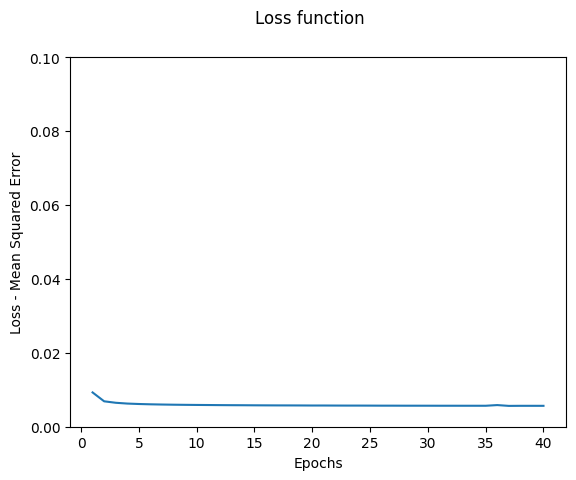

In [9]:
# Plotting loss function
fig, ax = plt.subplots()
ax.set_ylim(bottom=0, top=np.max(history_buffer).round(1) + 0.1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss - Mean Squared Error')
ax.plot(list(range(1, len(history_buffer) + 1)), history_buffer)
fig.suptitle('Loss function')

In [10]:
# Check for overfitting by calculating loss for testing data set
y_test = x_test.copy() # input equals output for outoencoders
Net.evaluate(x_test, y_test)

313/313 [==============================] - 3s 7ms/step - loss: 0.0057


0.0056732711382210255

1/1 [==============================] - 0s 133ms/step


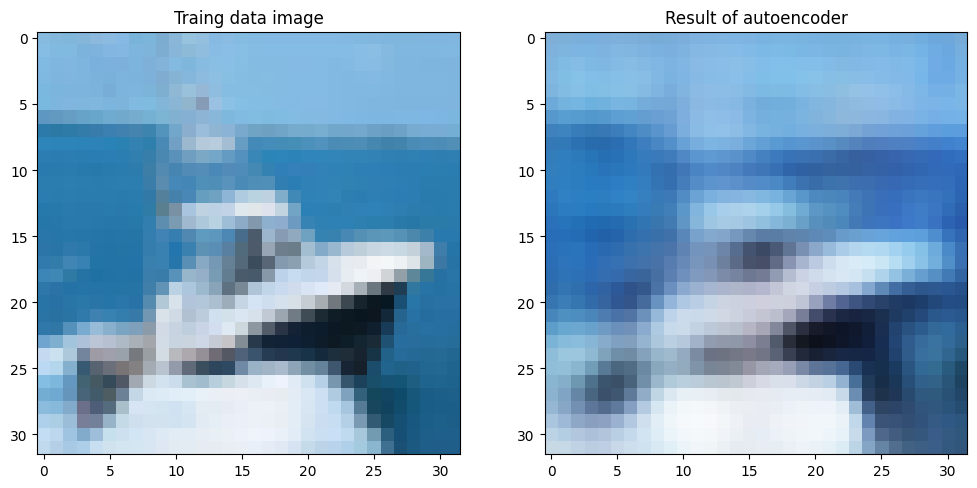

In [11]:
# Visualize result for samples of training data set

# Calculate prediction for training data set (first 10)
predicts_train = Net.predict(x_train[:10])

i = 8 #index to step through training data set for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 26))
axs[0].set_title('Traing data image')
axs[1].set_title('Result of autoencoder')
axs[0].imshow(x_train[i], label='Training data image')
axs[1].imshow(predicts_train[i], label='Result of autoencoder')

1/1 [==============================] - 0s 20ms/step


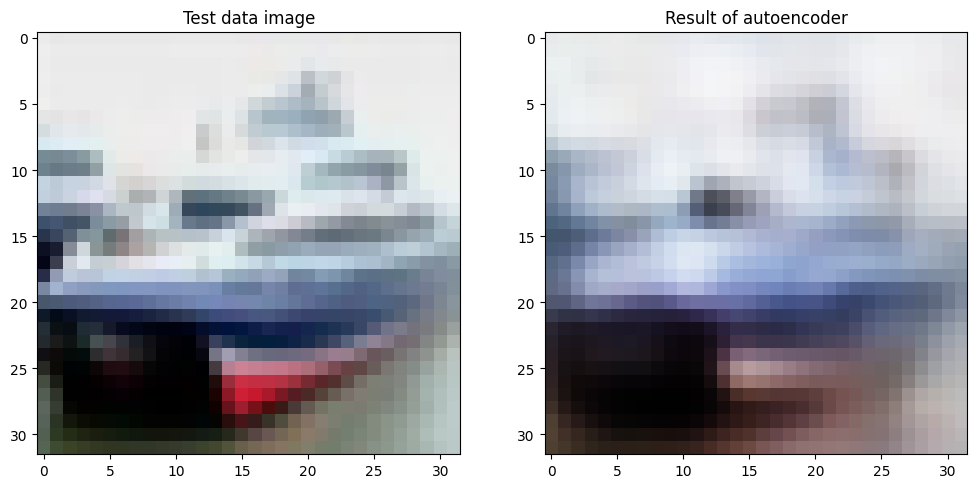

In [14]:
# Visualize result for samples of test data set

# Calculate prediction for test data set (first 10)
predicts_test = Net.predict(x_test[:10])

i = 1 #index to step through training data set for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 26))
axs[0].set_title('Test data image')
axs[1].set_title('Result of autoencoder')
axs[0].imshow(x_test[i], label='Test data image')
axs[1].imshow(predicts_test[i], label='Result of autoencoder')

In [15]:
# Saving trained net to file
Net.save('trained_autoencoder')

### Extracting bottleneck layer activations from trained autoencoder

In [16]:
# Setting up network similar to Net, but truncated at bottleneck. Will filled with trained weights
activ_enc = 'selu'

Encoder = ks.Sequential()
Encoder.add(ks.layers.Conv2D(16, 3, activation=activ_enc, padding='same', input_shape=(32, 32, 3), 
                            weights=Net.layers[0].get_weights()))
Encoder.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 32x32 to 16x16
Encoder.add(ks.layers.Conv2D(32, 3, activation=activ_enc, padding='same', 
                            weights=Net.layers[2].get_weights()))
Encoder.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 16x16 to 8x8
Encoder.add(ks.layers.Conv2D(64, 3, activation=activ_enc, padding='same',
                            weights=Net.layers[4].get_weights()))
Encoder.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 8x8 to 4x4
Encoder.add(ks.layers.Conv2D(8, 3, activation=activ_enc, padding='same',
                            weights=Net.layers[6].get_weights()))
Encoder.compile(optimizer='adam')

In [18]:
# To check correct operation decoder is set up as well. Later comparisson between applying
# encoder and then decoder to applying trained net as such.

# storing activation function
activ_dec = 'selu'

Decoder = ks.Sequential()
Decoder.add(ks.layers.UpSampling2D(size=(2, 2), input_shape=(4, 4, 8))) # From 4x4 to 8x8
Decoder.add(ks.layers.Conv2D(64, 3, activation=activ_dec, padding='same', 
                             weights=Net.layers[8].get_weights()))
Decoder.add(ks.layers.UpSampling2D(size=(2, 2))) # From 8x8 to 16x16
Decoder.add(ks.layers.Conv2D(32, 3, activation=activ_dec, padding='same', 
                             weights=Net.layers[10].get_weights()))
Decoder.add(ks.layers.UpSampling2D(size=(2, 2))) # From 16x16 to 32x32
Decoder.add(ks.layers.Conv2D(16, 3, activation=activ_dec, padding='same', 
                            weights=Net.layers[12].get_weights()))
Decoder.add(ks.layers.Conv2D(3, 5, activation='sigmoid', padding='same', 
                             weights=Net.layers[13].get_weights())) # Output layer with 3 color channels
Decoder.compile(optimizer='adam')

# Checking correct operation by comparing outputs of Net with output of encoder+decoder for first 10
# test sample pictures.
predicts_test_en_decoder = Decoder.predict(Encoder.predict(x_test[:10]))
print('Is prediction of Net equal to prediction of encoder + decoder: ', 
      np.array_equal(predicts_test, predicts_test_en_decoder))

1/1 [==============================] - 0s 83ms/step
Is prediction of Net equal to prediction of encoder + decoder:  True


In [19]:
# Storing activations in blottleneck for first 10000 training data images
# Adding layer to flatten outputs
Encoder.add(ks.layers.Flatten())
Encoder.compile(optimizer='adam')
activations_bottleneck = Encoder.predict(x_train[:10000])
# Removing layer to flatten output
Encoder.pop()

313/313 [==============================] - 1s 2ms/step


## T-SNE on bottleneck activations

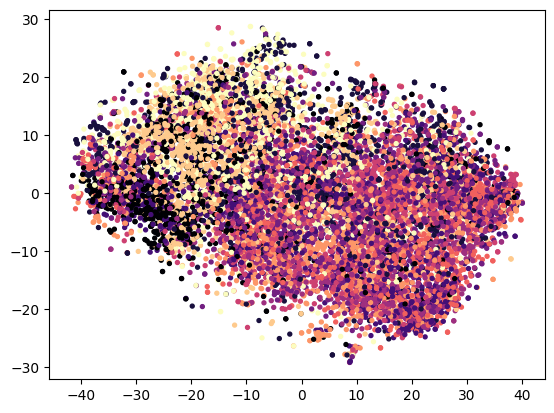

In [20]:
np.random.seed(100)
tsne = TSNE(n_iter=1000, perplexity=50)
tsne_result = tsne.fit_transform(activations_bottleneck[:10000])
fig, ax = plt.subplots()
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_cat_train[:10000], cmap='magma', s=8)

## For comparison: t-SNE on MNIST data set

In [ ]:
# Load MNIST dataset
(x_mnist, y_mnist), (_, _) = ks.datasets.mnist.load_data()

In [ ]:
# Flatten innermost dimensions to obtain vectors of length no. of pixel
x_input = x_mnist.reshape(60000, 784)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 739.435049
[t-SNE] Computed conditional probabilities in 0.089s
[t-SNE] Iteration 50: error = 66.3600311, gradient norm = 0.0000010 (50 iterations in 0.290s)
[t-SNE] Iteration 100: error = 66.3600235, gradient norm = 0.0000005 (50 iterations in 0.151s)
[t-SNE] Iteration 150: error = 66.3600311, gradient norm = 0.0000002 (50 iterations in 0.162s)
[t-SNE] Iteration 200: error = 66.3600235, gradient norm = 0.0000001 (50 iterations in 0.153s)
[t-SNE] Iteration 200: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 200 iterations with early exaggeration: 66.360023
[t-SNE] Iteration 250: error = 1.1971729, gradient norm = 0.0172480 (50 iterations in 0.174s)
[t-SNE] Iteration 300: error = 0.9666275, gradient norm = 0.0101297 (50 iterations in 0.249s)
[t-SNE

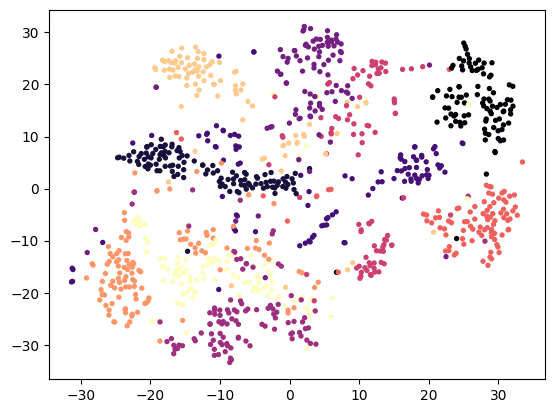

In [ ]:
# Set random seed for reproducability
np.random.seed(779)
# Generate instance of TSNE class
tsne_mnist = TSNE(n_iter=1000, perplexity=40, verbose=2)
# Perform t-SNE on some samples
tsne_result = tsne_mnist.fit_transform(x_input[:1000])
# Plot resulting 2D map with colors showing digit number of MNIST image
fig, ax = plt.subplots()
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_mnist[:1000], cmap='magma', s=8)